In [754]:
import pandas as pd
import numpy as np
from statsmodels.tsa.ar_model import AutoReg
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy.stats import norm
import statsmodels.api as sm
from arch.unitroot import ADF
from statsmodels.discrete.discrete_model import Probit

In [755]:
DEFAULT_FIGSIZE = (48,18)
plt.rc("figure", figsize=DEFAULT_FIGSIZE)
plt.rc("font", size=48)

def plot(s, y=DEFAULT_FIGSIZE):
    #figsize(y=y)
    fig, ax = plt.subplots(1, 1)
    if isinstance(s, pd.Series):
        s.plot(ax=ax, legend=False, color=["orange"])
    else:
        s.plot(ax=ax, legend=False)
        fig.legend(frameon=False)
    
    ax.set_xlabel(None)
    ax.set_xlim(s.index[0], s.index[-1]) #s.index[0]
    sns.despine()
    fig.tight_layout(pad=1.0)
    #figsize()

In [756]:
## is a questionable decision to use dm: essentially stating forecast only lost if it lost really really badly

def diebold_mariano(loss_a, loss_b, nw_bandwidth,cv):
    delta = loss_a - loss_b
    mod = sm.OLS(delta, np.ones_like(delta))
    dm_res = mod.fit(cov_type="HAC", cov_kwds={"maxlags":int(nw_bandwidth)})
    av_diff = delta.mean()
    a  = dm_res.bse[0]
    dm_stat = float(av_diff / a)  

    #cv = norm.ppf(0.975)

    if dm_stat < (cv * -1):
        concl = 1
    else:
        concl = 0


    return concl

QUESTION 1
--

In [809]:
rg.standard_normal(10000).var()

1.0028387128247502

In [897]:
len(theta_100)

10000

In [1039]:
# Simulate some data
# run time ~ 1 minute

# True simulated data ## Sample size 100
rg = np.random.RandomState(100)

r = [0.90, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]
runs = 1000
true_100 = {}
size = 100
nw = size ** (1/3)
cv = norm.ppf(0.95)
theta_100 = []
dm_100 = []

for rho in r:
    print(rho)
    for run in range(runs):
        start = rg.normal(0,1/(1-(rho**2)))
        run_holder = []
        run_holder.append(start)

        for i in range(1,size):
            shock = rg.standard_normal()
            last_val = run_holder[-1]
            new_val = last_val * rho + shock
            run_holder.append(new_val)

        y = np.asarray(run_holder)

        # Fit using first half, tau//2
        mod = AutoReg(y[:size//2], lags=1, trend="c", old_names=False)
        res = mod.fit()

        # Full-sample model
        oos_mod = AutoReg(y, lags=1, trend="c", old_names=False)

        # One-step predictions
        oos_1step = oos_mod.predict(res.params)

        # OOS Random Walk predictions
        oos_rw = oos_mod.predict([0, 1])

        # Get second half of both
        # Use -tau//2: to get second half
        oos_1step = oos_1step[-size//2:]
        oos_rw = oos_rw[-size//2:]

        # Calculate the losses
        loss_1step = (oos_1step - y[-size//2:]) ** 2
        loss_rw = (oos_rw - y[-size//2:]) ** 2

        evaluation = (loss_1step - loss_rw).sum()

        if evaluation > 0:
            mark = 1
        else:
            mark = 0

        # Append the estimated thetas and the DM results into lists
        theta_100.append(res.params[1])
        dm_100.append(mark)

        #dm_100.append(diebold_mariano( loss_rw, loss_1step, nw, cv))

theta_100 = np.asarray(theta_100)
dm_100 = np.asarray(dm_100)

0.9
0.91
0.92
0.93
0.94
0.95
0.96
0.97
0.98
0.99


In [1065]:
# Proportion of fails:
np.mean(loss_1step)

1.03568978228406

In [1154]:
len(theta_100)

10000

In [1239]:
app_dist = pd.DataFrame([theta_100,dm_100]).T
app_dist.columns = ["Theta^", "DM res"]
app_dist = app_dist.sort_values("Theta^")

sampled_theta = []
sampled_dm = []

block = [1000,2000,3000,4000,5000,6000,7000,8000,9000]
# two number multiply to give total runs * rho
for i in range(10000):
    if i in block:
        print(i)
    start = i -100
    end = i + 100
    sampled_theta.append(app_dist["Theta^"][start:end].mean())
    sampled_dm.append(app_dist["DM res"][start:end].mean())

sampled_theta = np.asarray(sampled_theta)
sampled_dm = np.asarray(sampled_dm)

app_dist = pd.DataFrame([sampled_theta,sampled_dm]).T
app_dist.columns = ["Theta^", "DM res"]
app_dist = app_dist.dropna()

1000
2000
3000
4000
5000
6000
7000
8000
9000


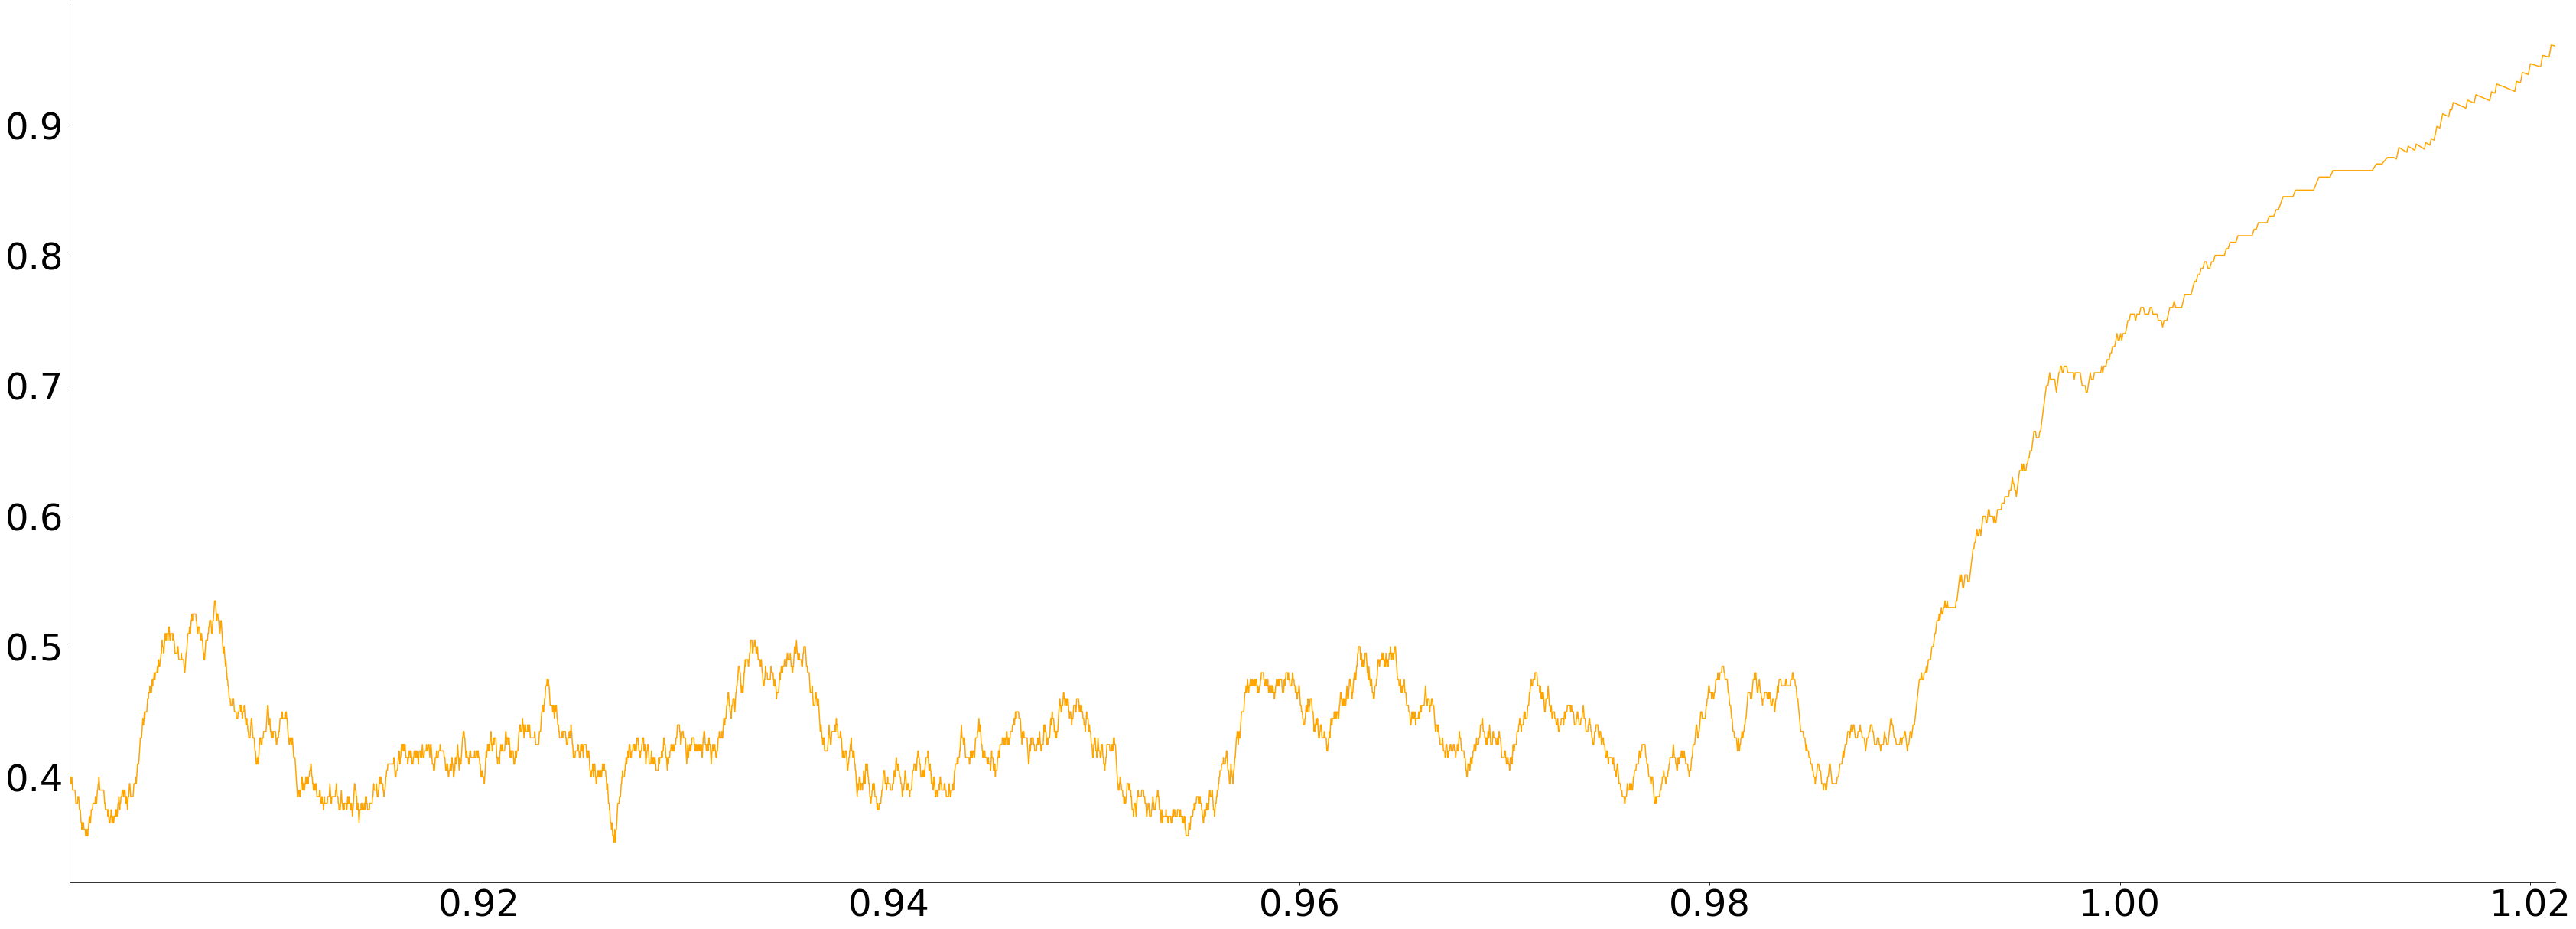

In [1240]:
# Full Plot - see the issue of extreme underestimation in half the sample when showing full sample : hence restrict between 0.9 and 1.03
app_dist.index =app_dist["Theta^"]
plot(app_dist["DM res"][0.9:1.03])

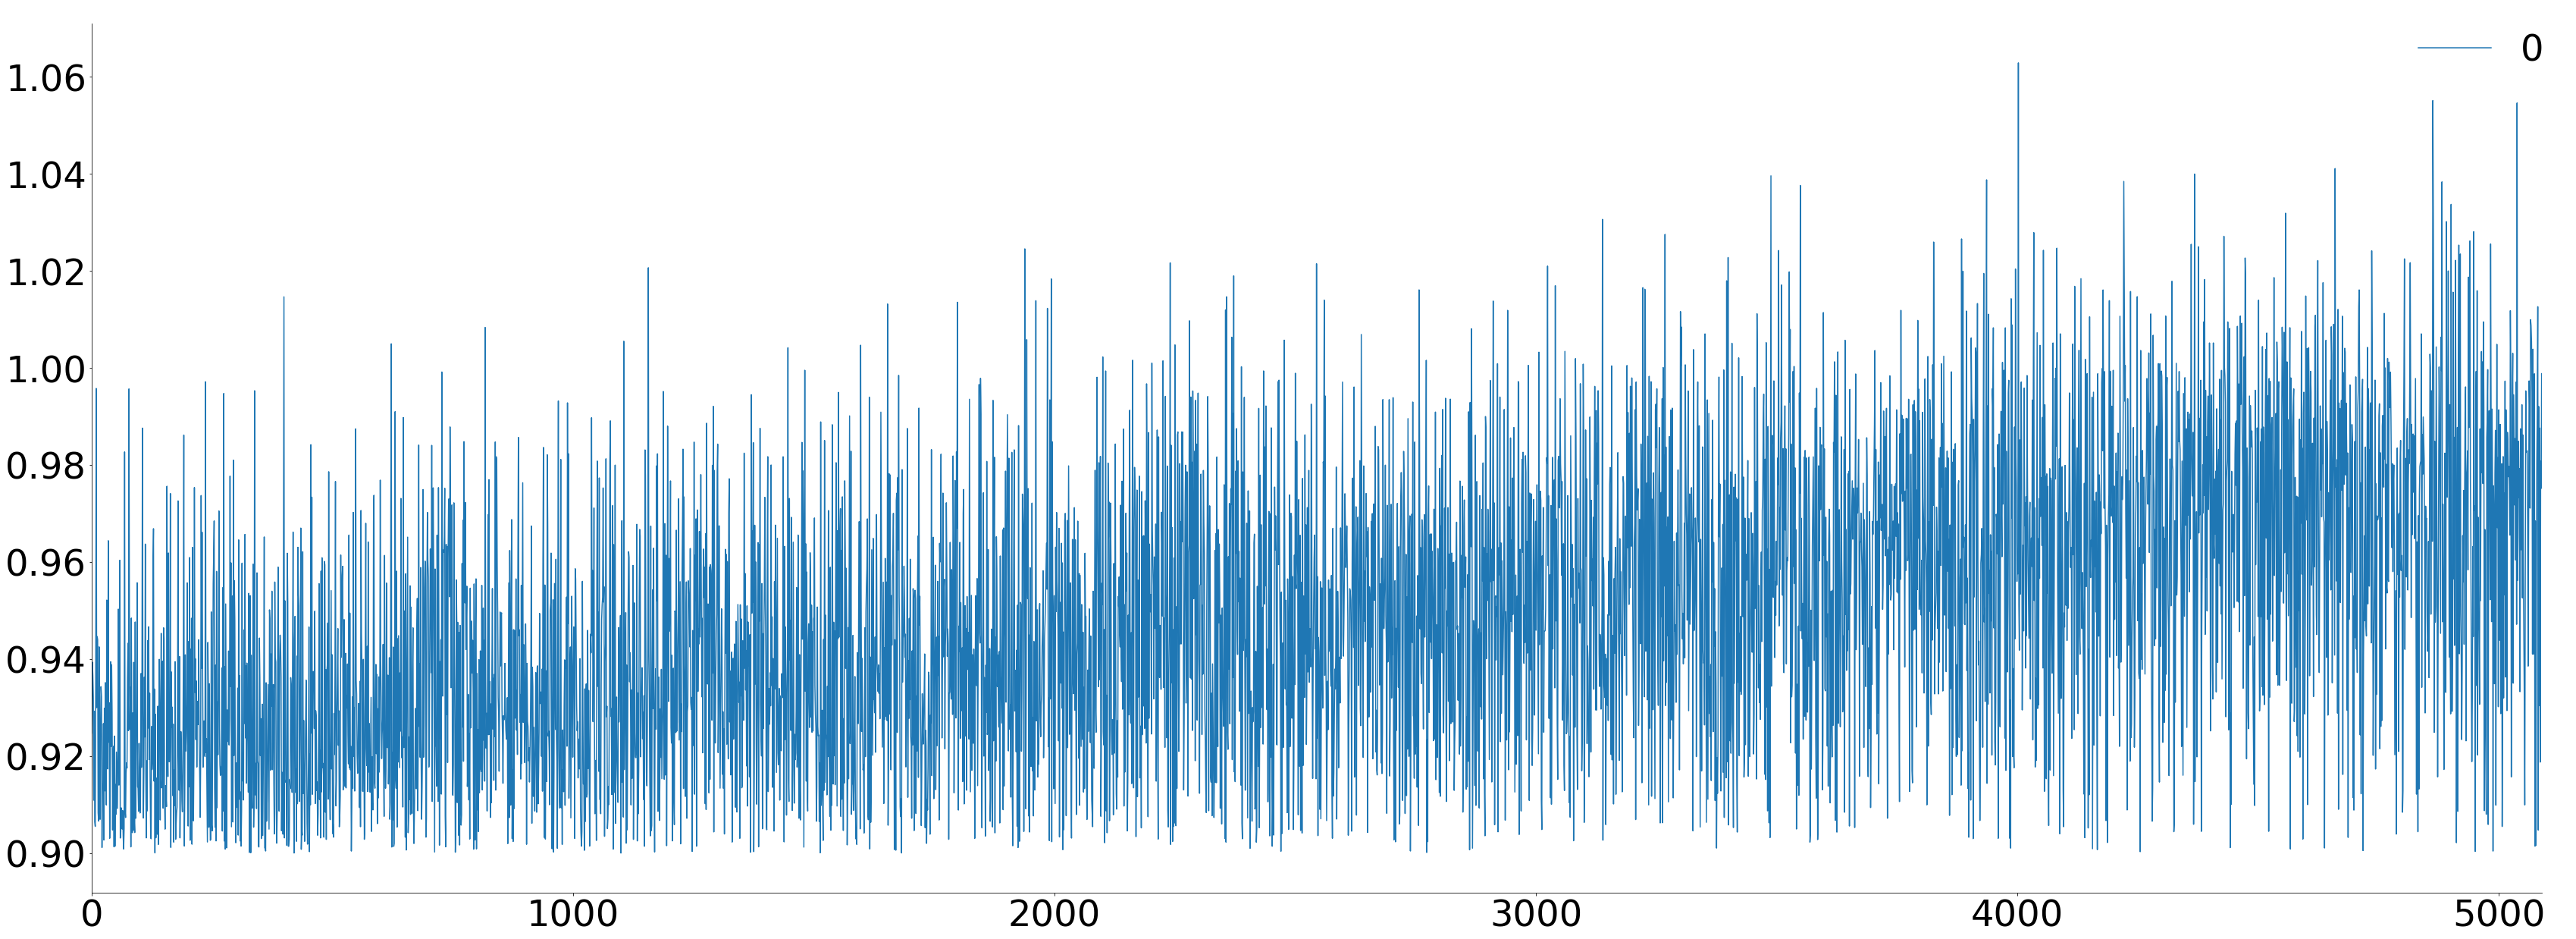

In [1002]:
plot(pd.DataFrame(theta_100_ninety))

-------

------

So we would rather apply a continuous model: using the PROBIT binary regression

In [1232]:
#  PROBIT MODEL, with estimated thetas above 0.90

theta_100_ninety = theta_100[np.where(theta_100>0.90)]
dm_100_ninety = dm_100[np.where(theta_100>0.90)]

model = Probit(dm_100_ninety, sm.add_constant(theta_100_ninety),cov_type = "HAC")
probit_model = model.fit()
probit_model.summary()

Optimization terminated successfully.
         Current function value: 0.681936
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 5091
Model:                         Probit   Df Residuals:                     5089
Method:                           MLE   Df Model:                            1
Date:                Sun, 14 Mar 2021   Pseudo R-squ.:                 0.01091
Time:                        13:32:42   Log-Likelihood:                -3471.7
converged:                       True   LL-Null:                       -3510.0
Covariance Type:            nonrobust   LLR p-value:                 2.102e-18
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.1105      0.575     -8.886      0.000      -6.238      -3.983
x1             5.2739      0.606      8.702      0.000       4.086       6.462
==============================================================================
"""

In [926]:
app_dist[9000:10000].mean()

Theta^    0.944663
DM res    0.610200
dtype: float64

In [1211]:
# Average marginal effect of theta on the probability at each observation
probit_model.get_margeff(at="overall", method='dydx', atexog=None, dummy=False, count=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
       Probit Marginal Effects       
=====================================
Dep. Variable:                      y
Method:                          dydx
At:                           overall
==============================================================================
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.0670      0.232      8.911      0.000       1.612       2.522
==============================================================================
"""

In [1238]:
# function expressing the probability of a dm rejection in terms of the estimated
norm.cdf(probit_model.params[0] + 0.9 * probit_model.params[1]).mean()

0.3579245270256404

In [1227]:
# function expressing the average probability of a dm rejection in terms of the estimated
print(norm.cdf(probit_model.params[0] + theta_100_ninety * probit_model.params[1]).mean())

# Value of theta at which it is better to approximate the distribution with a random walk
(norm.ppf(0.5) - probit_model.params[0]) / probit_model.params[1]

0.4573199351728044


0.9690216094351627

In [885]:
print(theta_100 * probit_model.params[1])

[0.05295908 0.05805377 0.05155027 ... 0.06273433 0.06170107 0.05767693]


In [934]:
probit_plot = pd.DataFrame([norm.cdf(probit_model.params[0] + theta_100 * probit_model.params[1]),theta_100]).T
#probit_plot.index = theta_100
probit_plot.columns = ["Theta^", "DM res"]

sampled_theta = []
sampled_dm = []

block = [1000,2000,3000,4000,5000,6000,7000,8000,9000]
# two number multiply to give total runs * rho
for i in range(9900):
    if i in block:
        print(i)
    start = i 
    end = i + 100
    sampled_theta.append(probit_plot["Theta^"][start:end].mean())
    sampled_dm.append(probit_plot["DM res"][start:end].mean())

sampled_theta = np.asarray(sampled_theta)
sampled_dm = np.asarray(sampled_dm)

probit_plot = pd.DataFrame([sampled_theta,sampled_dm]).T
probit_plot.columns = ["DM res","Theta^"]

#plot(probit_plot)

1000
2000
3000
4000
5000
6000
7000
8000
9000


In [935]:
probit_plot

,DM res,Theta^
0,0.608355,0.822870
1,0.610611,0.820783
2,0.610747,0.820677
3,0.611014,0.820456
4,0.611855,0.819770
...,...,...
9895,0.451417,0.950915
9896,0.449989,0.952039
9897,0.449419,0.952489
9898,0.449327,0.952564


In [867]:
np.max(probit_model.predict())

0.991156863544747

In [870]:
np.mean(dm_100)

0.53282

QUESTION 2
--

In [445]:
# Simulate some data
# run time ~ 1 minute

# True simulated data ## Sample size 100
rg = np.random.RandomState(100)

r = [0.90, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]
runs = 1000
size = 100
nw = size ** (1/3)
cv = norm.ppf(0.975)
theta_100_2 = []
dm_100_2 = []

for rho in r:
    print(rho)
    for run in range(runs):
        start = rg.normal(0,1/(1-(rho**2)))
        run_holder = []
        run_holder.append(start)

        for i in range(1,size):
            shock = rg.standard_normal()
            last_val = run_holder[-1]
            new_val = last_val * rho + shock
            run_holder.append(new_val)
            
        y = np.asarray(run_holder)

        # Fit using first half, tau//2
        mod = AutoReg(y[:size//2], lags=1, trend="c", old_names=False)
        res = mod.fit()

        # Full-sample model
        oos_mod = AutoReg(y, lags=1, trend="c", old_names=False)

        # OOS Random Walk predictions
        oos_rw = oos_mod.predict([0, 1])

        ## ADF test, and forecasting
        adf = ADF(y[-size//2:]).pvalue

        if adf > 0.05:
            oos_1step = oos_rw
            
        else:
            oos_1step = oos_mod.predict(res.params)


        # Get second half of both
        # Use -size//2: to get second half
        oos_1step = oos_1step[-size//2:]
        oos_rw = oos_rw[-size//2:]

        # Calculate the losses
        loss_1step = (oos_1step - y[-size//2:]) ** 2
        loss_rw = (oos_rw - y[-size//2:]) ** 2

        evaluation = (loss_1step - loss_rw).sum()

        if evaluation > 0:
            mark = 1
        else:
            mark = 0

        # Append the estimated thetas and the DM results into lists
        theta_100_2.append(res.params[1])
        dm_100_2.append(mark)




0.9
0.91
0.92
0.93
0.94
0.95
0.96
0.97
0.98
0.99


In [1022]:
print("% of runs where the forecast is beaten by a random walk (where a rw has not been preselected")
print(f" {np.mean(dm_100_2) * 100}%")
print()
print("Compared to previously:")
print(f"{np.round(np.mean(dm_100)*100,3)}%")
print()
print("Huge Improvement")

% of runs where the forecast is beaten by a random walk (where a rw has not been preselected
 5.56%

Compared to previously:
53.2%

Huge Improvement


Question 3
---

In [1098]:
x.std(ddof=0)

const    0.000000
0        2.644067
dtype: float64

In [1118]:

# estimate the difference and apply LASSO
from sklearn.linear_model import LassoCV, RidgeCV
def lasso_reg(x,y):

    x_scale = x.std(ddof=0)[0]
    y_scale = y.std(ddof=0)
    std_x = x / x_scale
    std_y = y / y_scale
    std_x = std_x

    lasso_cv = LassoCV(fit_intercept=True)
    lasso_cv = lasso_cv.fit(std_x,std_y)
    #print(f"Optimal Alpha = {lasso_cv.alpha_}")
    lasso_beta = lasso_cv.coef_[1]  * (y_scale / x_scale)
    lasso_intercept = lasso_cv.intercept_ * (y_scale / x_scale)
    alpha = lasso_cv.alpha_
    return lasso_intercept, lasso_beta, alpha


In [1123]:
""" Second Method"""

# True simulated data ## Sample size 100
rg = np.random.RandomState(100)

r = [0.90, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]
runs = 1000
size = 100
nw = size ** (1/3)
cv = norm.ppf(0.95)
theta_100_3 = []
dm_100_3 = []
est_rho_100 = []
alpha_100 = []

for rho in r:
    print(rho)

    for run in range(runs):
        start = rg.normal(0,1/(1-(rho**2)))
        run_holder = []
        run_holder.append(start)

        for i in range(1,size):
            shock = rg.standard_normal()
            last_val = run_holder[-1]
            new_val = last_val * rho + shock
            run_holder.append(new_val)
            
        y = pd.Series(run_holder)
        y_diff = y.diff()

        # Fit using first half, size//2
        x = sm.add_constant(y.shift(1).dropna()[:size//2])
        dep = y_diff[1:].dropna()[:size//2]

        a, b, alpha = lasso_reg(x,dep)

        #res = sm.OLS(dep,x).fit()
        #a, b = res.params

        mod = AutoReg(y[:(size//2)], lags=1, trend="c", old_names=False)
        theta = mod.fit().params[1]
        #res = mod.fit()

        # Full-sample model
        oos_mod = AutoReg(y, lags=1, trend="c", old_names=False)

        # OOS Random Walk predictions
        oos_rw = oos_mod.predict([0, 1])

        # Model forecasts
        #oos_1step = oos_mod.predict(res.params)
        #oos_1step = res.params * y_diff

        est = []
        for i in range(1,100):
            a = a
            t_1 = y[i-1]
            e = a + t_1 * (b) + t_1
            est.append(e)
        oos_1step = np.asarray(est)


        # Get second half of both
        # Use -size//2: to get second half
        oos_1step = oos_1step[-(size//2):]
        oos_rw = oos_rw[-size//2:]

        # Calculate the losses
        loss_1step = (oos_1step - y[-size//2:]) ** 2
        loss_rw = (oos_rw - y[-size//2:]) ** 2

        evaluation = (loss_1step - loss_rw).sum()

        if evaluation > 0:
            mark = 1
        else:
            mark = 0

        # Append the estimated thetas and the DM results into lists
        alpha_100.append(alpha)
        theta_100_3.append(theta)
        est_rho_100.append(b)
        dm_100_3.append(mark)

theta_100_3 = np.asarray(theta_100_3)
dm_100_3 = np.asarray(dm_100_3)


0.9
0.91
0.92
0.93
0.94
0.95
0.96
0.97
0.98
0.99


In [1108]:
np.mean(theta_100_3 - est_rho)

0.9534133448421414

In [1129]:
alpha_100 = np.asarray(alpha_100)

In [1244]:
# Optimal Shrinkage as a function of the OLS estimate theta^
alpha_100_ninety = alpha_100[np.where(theta_100_3>0.90)]
sm.OLS(alpha_100,theta_100_3).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.681
Model:                            OLS   Adj. R-squared (uncentered):              0.681
Method:                 Least Squares   F-statistic:                          2.132e+04
Date:                Sun, 14 Mar 2021   Prob (F-statistic):                        0.00
Time:                        13:36:14   Log-Likelihood:                          11767.
No. Observations:               10000   AIC:                                 -2.353e+04
Df Residuals:                    9999   BIC:                                 -2.353e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1225      0.001    145.999      0.000       0.121       0.124
==============================================================================
Omnibus:                      389.991   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              434.146
Skew:                           0.506   Prob(JB):                     5.32e-95
Kurtosis:                       2.869   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1142]:
np.mean(loss_1step)

1.1054209445033167

In [1252]:
# PROBIT MODEL

theta_100_3_ninety = theta_100_3[np.where(theta_100_3>0.90)]
dm_100_3_ninety = dm_100_3[np.where(theta_100_3>0.90)]
alpha_100_ninety = alpha_100[np.where(theta_100_3>0.90)]

model = Probit(dm_100_3_ninety, sm.add_constant(theta_100_3_ninety))
probit_model = model.fit()
probit_model.summary()

Optimization terminated successfully.
         Current function value: 0.659307
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 5091
Model:                         Probit   Df Residuals:                     5089
Method:                           MLE   Df Model:                            1
Date:                Sun, 14 Mar 2021   Pseudo R-squ.:                0.004144
Time:                        13:37:35   Log-Likelihood:                -3356.5
converged:                       True   LL-Null:                       -3370.5
Covariance Type:            nonrobust   LLR p-value:                 1.254e-07
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.3644      0.578     -5.823      0.000      -4.497      -2.232
x1             3.2125      0.608      5.279      0.000       2.020       4.405
==============================================================================
"""

In [1256]:
# function expressing the probability of a dm rejection in terms of the estimated
print(norm.cdf(probit_model.params[0] + theta_100_3 * probit_model.params[1]))

# Value of theta at which it is better to approximate the distribution with a random walk
(norm.ppf(0.5) - probit_model.params[0]) / probit_model.params[1]

[0.256412   0.34688523 0.23375459 ... 0.43816002 0.43094855 0.23818905]


1.047309601132114

In [1115]:
probit_model.params[1]

3.2124629411706387

In [1258]:
print("% of runs where the forecast is beaten by a random walk (where a rw has not been preselected")
print(f" {np.mean(dm_100_3) * 100}%")
print()
print("Compared to previously:")
print(f"{np.round(np.mean(dm_100)*100,3)}%")
print()
print("A little better, but not as good as selecting for a unit root")

% of runs where the forecast is beaten by a random walk (where a rw has not been preselected
 39.44%

Compared to previously:
53.2%

A little better, but not as good as selecting for a unit root
